### Multi Class classification 

##### Importing Libraries

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

Transfer Learning

Here we use a transfer learning model.Transfer Learning allows us to apply features already learned from other datasets to our dataset, leading to lower training times and higher accuracies.

##### Set device and hyperparameters

In [2]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set Hyperparameters
num_epochs = 200
num_classes = 50
batch_size = 64
learning_rate = 1e-4
train_split = 0.8
val_split = 0.1
n_iter_stop = 10
torch.manual_seed(0)

##### Load data with some transforms operations for augmentation

In [3]:
# define transforms for data augmentation
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Load data -- Dataset is present in BarkVN-50_mendeley folder in the same directory as this file
dataset = datasets.ImageFolder(root='BarkVN-50_mendeley', transform=trans)

##### Data Exploration

We plot our data distribution and observe that our data has 50 classes/directories with roughly 100 images in each directory.

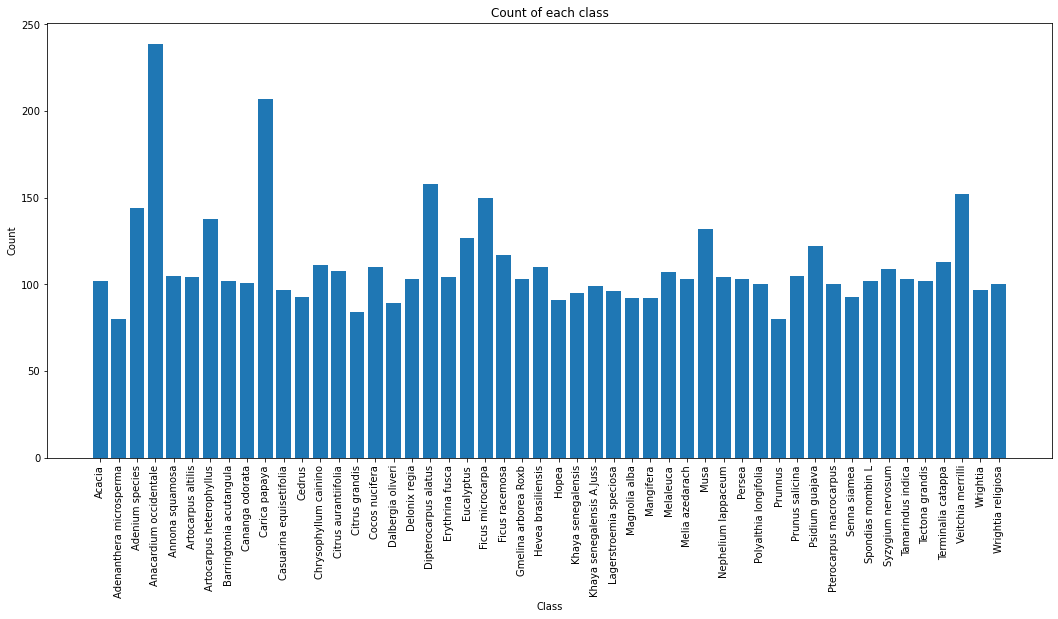

In [4]:
# visualize count of each class
classes = dataset.classes
class_count = [0] * len(classes)
for _, label in dataset:
    class_count[label] += 1
plt.figure(figsize=(18, 8))
plt.bar(classes, class_count)
plt.xticks(rotation=90)
plt.title('Count of each class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Some images from the dataset


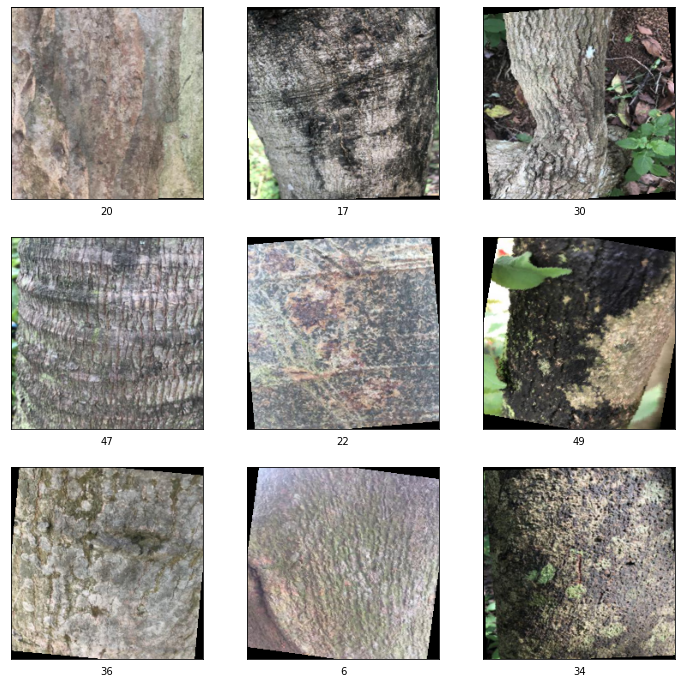

In [5]:
# plot some images to see what we are dealing with
plt.figure(figsize=(12,12))

for j,i in enumerate(np.random.randint(0, len(dataset), 9)):
    plt.subplot(3,3,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(torch.permute(dataset[i][0],(1, 2, 0)).numpy())
    plt.xlabel(dataset[i][1])

print('Some images from the dataset')
plt.show()

#### Spliting data with 
###### train 80%
###### dev set 10%
###### test 10%

In [6]:
#split data into train and test and validate
train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### Load Pretrained Resnet50 model and apply transfer learning!!!

In [7]:
# Load pretrained model
model = models.resnet50(weights=models. ResNet50_Weights.DEFAULT)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Replace last layer for transfer learning since we have 50 classes
model.fc = nn.Sequential(
                      nn.Linear(model.fc.in_features, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes),                   
                      nn.LogSoftmax(dim=1))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\jayan/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100.0%


##### Train Model to update the weights of modified fully connected layer


Epoch [0/200] train_Loss: 263.2584 Val_Loss: 32.1611 Validation accuracy: 18.49
Epoch [1/200] train_Loss: 231.2894 Val_Loss: 27.6203 Validation accuracy: 40.04
Epoch [2/200] train_Loss: 196.7229 Val_Loss: 23.6009 Validation accuracy: 51.35
Epoch [3/200] train_Loss: 167.2903 Val_Loss: 20.4162 Validation accuracy: 57.45
Epoch [4/200] train_Loss: 141.0020 Val_Loss: 17.2603 Validation accuracy: 66.79
Epoch [5/200] train_Loss: 121.0984 Val_Loss: 14.5178 Validation accuracy: 72.71
Epoch [6/200] train_Loss: 106.0514 Val_Loss: 12.8124 Validation accuracy: 77.20
Epoch [7/200] train_Loss: 93.1731 Val_Loss: 11.4666 Validation accuracy: 78.10
Epoch [8/200] train_Loss: 82.4255 Val_Loss: 10.5572 Validation accuracy: 80.07
Epoch [9/200] train_Loss: 74.6531 Val_Loss: 9.4707 Validation accuracy: 80.07
Epoch [10/200] train_Loss: 67.9725 Val_Loss: 8.9942 Validation accuracy: 80.43
Epoch [11/200] train_Loss: 62.7477 Val_Loss: 8.2457 Validation accuracy: 81.69
Epoch [12/200] train_Loss: 57.5309 Val_Loss: 7

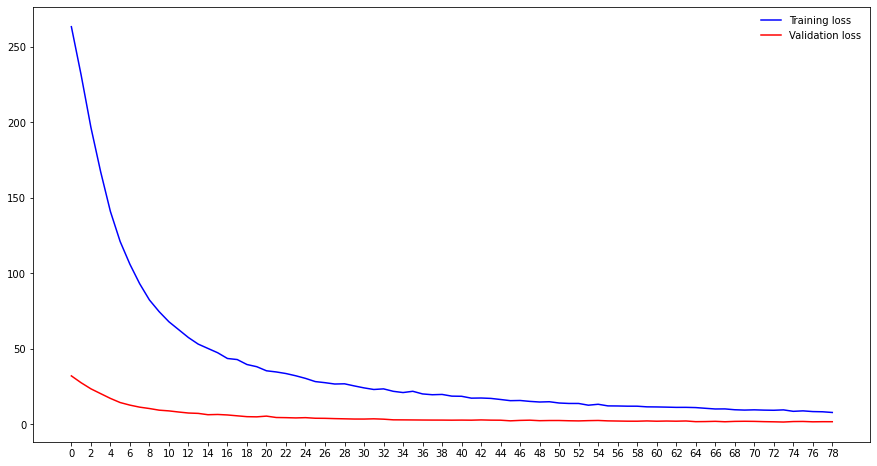

In [8]:
## Tracked validation accuracy to early stop
## If no improvement in validation accuracy for 10 consecutive epochs, training will be stopped.

# Initialize model
model = model.to(device)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Traininig loop
best_val_loss = float('inf')
best_val_acc = 0
best_model = None
train_losses = []
val_losses = []
counter = 0

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to device
        data = data.to(device)
        targets = targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    train_losses.append(train_loss)



    # Display validation accuracy after every epoch
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        val_loss = 0
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            val_loss += criterion(scores, targets)
            _, predictions = scores.max(1)
            n_correct += (predictions == targets).sum()
            n_samples += predictions.size(0)
        acc = 100.0 * n_correct/n_samples
        print(f'Epoch [{epoch}/{num_epochs}] train_Loss: {train_loss:.4f} Val_Loss: {val_loss:.4f} Validation accuracy: {acc:.2f}')

        val_losses.append(val_loss.item())

    # save best model
    if acc > best_val_acc:
        best_val_loss = val_loss.item()
        best_val_acc = acc
        best_model = model.state_dict()
        torch.save(best_model, 'model.ckpt')
        counter=0
    
    # early stopping
    elif acc <= best_val_acc:
        if counter >=n_iter_stop:
            print('Early stopping')
            break
        else:
            counter += 1

# Plot training and validation loss
plt.figure(figsize=(15,8))
t = [i for i in range(len(train_losses))]
plt.plot(t, train_losses, label='Training loss', color='blue')
plt.plot(t, val_losses, label='Validation loss', color='red')
# leave alternate points for better visualization
plt.xticks(t[::2])
plt.legend(frameon=False)
plt.show()

Load the saved model which is the best model where train and validation loss is minimum


In [9]:
# load model
model = models.resnet50(weights=models. ResNet50_Weights.DEFAULT)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

# Replace last layer for transfer learning
model.fc = nn.Sequential(
                      nn.Linear(model.fc.in_features, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes),                   
                      nn.LogSoftmax(dim=1))

model.load_state_dict(torch.load('model.ckpt'))
model = model.to(device)

Evaluating the model

Got 549 / 559 on test data with accuracy 98.21
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        13
           6       0.93      1.00      0.97        14
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00         8
          12       1.00      0.92      0.96        13
          13       1.00      1.00      1.00        10
          14       1.00      0.93      0.97        15
          15       1.00      1.00      1.00        12
          16

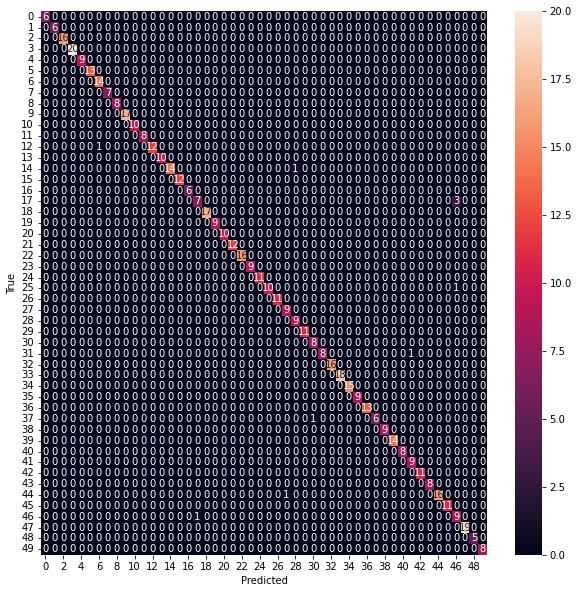

In [11]:
def evaluate_model(loader, model):
    y_pred = []
    y_true = []
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        print(
            f'Got {num_correct} / {num_samples} on test data with accuracy {float(num_correct)/float(num_samples)*100:.2f}'
        )

        print('Classification Report')
        print(classification_report(y_true, y_pred))


        print('Confusion Matrix')
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    model.train()


evaluate_model(test_loader, model)